# RLLAB setup scripts for google colab
Install packages with compatible versions

In [0]:
!apt-get -qq install -y xvfb python-opengl > /dev/null 2>&1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg > /dev/null

In [0]:
!pip install -q path.py
!pip install -q pyprind
!pip install -q cached_property
!pip install -q gym==0.7.4
!pip install -q theano==0.8.2
!pip install -q git+https://github.com/neocxi/Lasagne.git@484866cf8b38d878e92d521be445968531646bb8#egg=Lasagne
  
!pip install -q PyOpenGL piglet pyglet pyvirtualdisplay

stable-baselines 2.2.1 has requirement gym[atari,classic_control]>=0.10.9, but you'll have gym 0.7.4 which is incompatible.
dopamine-rl 1.0.5 has requirement gym>=0.10.5, but you'll have gym 0.7.4 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.0 which is incompatible.
pymc3 3.6 has requirement theano>=1.0.0, but you'll have theano 0.8.2 which is incompatible.


In [0]:
!pip install box2d-py mako==1.0.7 Pygame JSAnimation imageio

    100% |████████████████████████████████| 450kB 14.5MB/s 
    100% |████████████████████████████████| 573kB 24.8MB/s 
    100% |████████████████████████████████| 12.1MB 2.7MB/s 
  Running setup.py bdist_wheel for mako ... - \ done
  Stored in directory: /root/.cache/pip/wheels/15/35/25/dbcb848832ccb1a4b4ad23f529badfd3bce9bf88017f7ca510
  Running setup.py bdist_wheel for JSAnimation ... - done
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built mako JSAnimation


In [0]:
!git clone https://github.com/kekim/rllab.git rllab-git

Cloning into 'rllab-git'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 1440 (delta 9), reused 32 (delta 7), pack-reused 1395
Receiving objects: 100% (1440/1440), 1.55 MiB | 20.92 MiB/s, done.
Resolving deltas: 100% (769/769), done.


In [0]:
!cp -a ./rllab-git/* .

# Baseline on LunarLanderContinous-v2 (OpenAI Gym version)
**Important!**
Before running the following cell, make sure rllab is set up properly in your current runtime by executing codes in RLLAB setup scripts.

**1. Implement Baseline Algorithm**

- Import necessary packages
(Execute **once again** if you encounter an error)

In [0]:
from rllab.envs.gym_env import GymEnv
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.policies.gaussian_mlp_policy import GaussianMLPPolicy
from rllab.envs.normalized_env import normalize
import numpy as np
import theano
import theano.tensor as TT
from lasagne.updates import adam
from rllab.misc.instrument import run_experiment_lite
import rllab.misc.logger as logger

########## Baseline_GYM_Lunvar_v2_With_RUN_EXP_LITE ##########

- Implement Baseline algorithm

In [0]:
def Baseline(*_):
    # normalize() makes sure that the actions for the environment lies
    # within the range [-1, 1] (only works for environments with continuous actions)

    # normalize() makes sure that the actions for the environment lies
    # within the range [-1, 1] (only works for environments with continuous actions)
    env = normalize(GymEnv(env_name = "LunarLanderContinuous-v2", force_reset=True))
    # Initialize a neural network policy with a single hidden layer of 8 hidden units
    policy = GaussianMLPPolicy(env.spec, hidden_sizes=(32,32))
    # Initialize a linear baseline estimator using default hand-crafted features
    baseline = LinearFeatureBaseline(env.spec)

    # We will collect 100 trajectories per iteration
    N = 3
    # Each trajectory will have at most 100 time steps
    T = 400
    # Number of iterations
    n_itr = 1000
    # Set the discount factor for the problem
    discount = 0.99
    # Learning rate for the gradient update
    learning_rate = 0.001

    # Construct the computation graph

    # Create a Theano variable for storing the observations
    # We could have simply written `observations_var = TT.matrix('observations')` instead for this example. However,
    # doing it in a slightly more abstract way allows us to delegate to the environment for handling the correct data
    # type for the variable. For instance, for an environment with discrete observations, we might want to use integer
    # types if the observations are represented as one-hot vectors.
    observations_var = env.observation_space.new_tensor_variable(
        'observations',
        # It should have 1 extra dimension since we want to represent a list of observations
        extra_dims=1
    )
    actions_var = env.action_space.new_tensor_variable(
        'actions',
        extra_dims=1
    )
    advantages_var = TT.vector('advantages')

    # policy.dist_info_sym returns a dictionary, whose values are symbolic expressions for quantities related to the
    # distribution of the actions. For a Gaussian policy, it contains the mean and (log) standard deviation.
    dist_info_vars = policy.dist_info_sym(observations_var)

    # policy.distribution returns a distribution object under rllab.distributions. It contains many utilities for computing
    # distribution-related quantities, given the computed dist_info_vars. Below we use dist.log_likelihood_sym to compute
    # the symbolic log-likelihood. For this example, the corresponding distribution is an instance of the class
    # rllab.distributions.DiagonalGaussian
    dist = policy.distribution

    # Exp. #2, Prob.2: Define a proper loss function for Baseline
    ###########################################################################
    # Note that we negate the objective, since most optimizers assume a minimization problem
    surr = - TT.mean(dist.log_likelihood_sym(actions_var, dist_info_vars) * advantages_var)

    # Get the list of trainable parameters.
    params = policy.get_params(trainable=True)
    grads = theano.grad(surr, params)

    f_train = theano.function(
        inputs=[observations_var, actions_var, advantages_var],
        outputs=None,
        updates=adam(grads, params, learning_rate=learning_rate),
        allow_input_downcast=True
    )

    for epoch in range(n_itr):
        logger.push_prefix('epoch #%d | ' % epoch)
        logger.log("Training started")
        paths = []

        for _ in range(N):
            observations = []
            actions = []
            rewards = []

            observation = env.reset()

            for _ in range(T):
                # policy.get_action() returns a pair of values. The second one returns a dictionary, whose values contains
                # sufficient statistics for the action distribution. It should at least contain entries that would be
                # returned by calling policy.dist_info(), which is the non-symbolic analog of policy.dist_info_sym().
                # Storing these statistics is useful, e.g., when forming importance sampling ratios. In our case it is
                # not needed.
                action, _ = policy.get_action(observation)
                # Recall that the last entry of the tuple stores diagnostic information about the environment. In our
                # case it is not needed.
                next_observation, reward, terminal, _ = env.step(action)
                observations.append(observation)
                actions.append(action)
                rewards.append(reward)
                observation = next_observation
                if terminal:
                    # Finish rollout if terminal state reached
                    break

            # We need to compute the empirical return for each time step along the
            # trajectory
            path = dict(
                observations=np.array(observations),
                actions=np.array(actions),
                rewards=np.array(rewards),
            )
            path_baseline = baseline.predict(path)
            
            # Exp. #2, Prob.1: Calculate advantages and returns.
            ###########################################################################
            advantages = []
            returns = []
            return_so_far = 0
            for t in range(len(rewards) - 1, -1, -1):
                return_so_far = rewards[t] + discount * return_so_far
                returns.append(return_so_far)
                advantage = return_so_far - path_baseline[t]
                advantages.append(advantage)

            # The advantages are stored backwards in time, so we need to revert it
            advantages = np.array(advantages[::-1])

            # And we need to do the same thing for the list of returns
            returns = np.array(returns[::-1])

            # Normalizing advantages is known trick for reducing variance, similar to normalizing reward.
            advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

            path["advantages"] = advantages
            path["returns"] = returns

            paths.append(path)

        baseline.fit(paths)

        #### Dim. of observation: [Sum of length of all traj, Dim(observation)] ####
        observations = np.concatenate([p["observations"] for p in paths])

        #### Dim. of actions    : [Sum of length of all traj, Dim(action)]      ####
        actions = np.concatenate([p["actions"] for p in paths])

        #### Dim. of advantages : [sSm of length of all traj, ]                 ####
        advantages = np.concatenate([p["advantages"] for p in paths])

        f_train(observations, actions, advantages)
        returns_to_check = [sum(p["rewards"]) for p in paths]
        print('Average Return:', np.mean(returns_to_check))

        ############################################################################
        logger.log("Training finished")
        logger.save_itr_params(epoch, params)
        logger.dump_tabular(with_prefix=False)
        logger.pop_prefix()


        logger.record_tabular('Epoch', epoch)
        logger.record_tabular('Steps', epoch*N*T)
        logger.record_tabular('AverageReturn', np.mean(returns_to_check))
        logger.record_tabular('StdReturn', np.std(returns_to_check))
        logger.record_tabular('MaxReturn', np.max(returns_to_check))
        logger.record_tabular('MinReturn', np.min(returns_to_check))

**2. Execute Your Algorithm**

- Activate a virtual display

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

- Create & Run a RL task for Acrobot

In [0]:
mypath='./log/vpg_lunar_baseline/'

run_experiment_lite(
    Baseline,
    # Number of parallel workers for sampling
    log_dir=mypath,
    n_parallel=1,
    # Only keep the snapshot parameters for the last iteration
    snapshot_mode="last",
    # Specifies the seed for the experiment. If this is not provided, a random seed
    # will be used
    seed=1,
    # plot=True,
)

python /content/scripts/run_experiment_lite.py  --n_parallel '1'  --snapshot_mode 'last'  --seed '1'  --exp_name 'experiment_2019_01_15_05_03_42_0001'  --log_dir './log/vpg_lunar_baseline/'  --use_cloudpickle 'True'  --args_data 'gASVfgwAAAAAAACMF2Nsb3VkcGlja2xlLmNsb3VkcGlja2xllIwOX2ZpbGxfZnVuY3Rpb26Uk5QoaACMD19tYWtlX3NrZWxfZnVuY5STlGgAjA1fYnVpbHRpbl90eXBllJOUjAhDb2RlVHlwZZSFlFKUKEsASwBLJEsIS0dCbgMAAHQAdAFkAWQCZAONAoMBfQF0AnwBagNkKGQFjQJ9AnQEfAFqA4MBfQNkBn0EZAd9BWQIfQZkCX0HZAp9CHwBagVqBmQLZAxkDY0CfQl8AWoHagZkDmQMZA2NAn0KdAhqCWQPgwF9C3wCagp8CYMBfQx8AmoLfQ10CGoMfA1qDXwKfAyDAnwLFACDAQsAfQ58AmoOZAJkEI0BfQ90D2oQfA58D4MCfRB0D2oRfAl8CnwLZwNkAHQSfBB8D3wIZBGNA2QCZBKNBH0RkAJ4nnQTfAaDAUQAkAJdkH0SdBRqFWQTfBIWAIMBAQB0FGoWZBSDAQEAZwB9E5ABeGp0E3wEgwFEAJABXVx9AGcAfRRnAH0VZwB9FnwBaheDAH0XeFx0E3wFgwFEAF1QfQB8AmoYfBeDAVwCfRh9AHwBahl8GIMBXAR9GX0afRt9AHwUahp8F4MBAQB8FWoafBiDAQEAfBZqGnwagwEBAHwZfRd8G5ABciZQAJABcSZXAHQbdBxqHXwUgwF0HGodfBWDAXQcah18FoMBZBWNA30cfANqHnwcgwF9HWcAfR5nAH0fZBZ9IHhOdBN0H3wWgwFkDBgAZC

**3. Average Reward Plotting**

- You can evaluate how your agent is being trained with reward it gets in every iteration. 
- Whenever you execute the code 'run_experiment_lite', it will generate a experiment directory.
- (/content/log/vpg_lunar_baseline/)
- Please update the value of '**mypath**' and specify your new experiment directory name. 

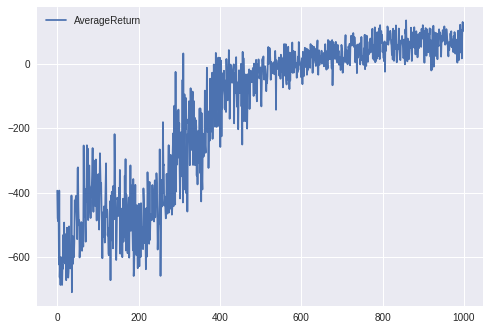

In [0]:
import os.path as osp
import numpy as np
import csv
import matplotlib.pyplot as plt
import json
import joblib
from glob import glob
import os

mypath = './log/vpg_lunar_baseline/'

plots = []
legends = []
returns = []
with open(osp.join(mypath, 'progress.csv'), 'rt') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['AverageReturn']:
            returns.append(float(row['AverageReturn']))
returns = np.array(returns)
plots.append(plt.plot(returns)[0])
legends.append('AverageReturn')
plt.legend(plots, legends)
plt.show()

**4. Play Videos of your Agent Behavior**

- You can watch how your agent's behavior improves.
- If you haven't update 'mypath' in the code above, you need to update it here.
- (/content/log/vpg_lunar_baseline/)

In [0]:
from IPython import display as pythondisplay
# from pyvirtualdisplay import Display

# from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

import imageio

from os import listdir
from os.path import isfile, join

def plot_movie_js(image_array, filename):
    dpi = 10.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/(dpi), xpixels/(dpi)), dpi=dpi)
    fig.suptitle(filename, fontsize=160)
    # fig.set_xlabel(filename, fontsize=160)
    # fig.xlabel(filename, fontsize=160)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    pythondisplay.display(IPython_display.display_animation(anim))

# mypath = './log/vpg_lunar_baseline/'
mypath += 'gym_log/'
mp4files = [f for f in listdir(mypath) if f.endswith(".mp4")]
mp4files.sort()


for filename in mp4files:
    vid = imageio.get_reader(join(mypath, filename),  'ffmpeg')
    # print(len(vid))
    # print(vid.get_data(0).shape)

    screenlist = []
    for i in range(len(vid)):
        image = vid.get_data(i)
        screenlist.append(image)
        # fig = plt.figure()
        # fig.suptitle('image #{}'.format(i), fontsize=20)
        # plt.imshow(image)

    plot_movie_js(screenlist, filename)
